In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fitsio

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table, hstack


# Set some plotting environment variables
sns.set(style='white', context='paper', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

In [13]:
fuji = Table(fitsio.read('fuji-matches.fits')) # table of all matches
iron = Table(fitsio.read('iron-matches.fits'))

# Let's explore the matches

In [4]:
# histogram various values

def fujiHist(key, table=fuji, **kwargs):
    '''
    key [str] : key that exists in the astropy Table
    table [astropy Table] : to plot from
    '''
    
    fig, ax = plt.subplots(1,1)
    
    ax.hist(table[key], color='cornflowerblue', **kwargs)
    ax.set_ylabel('N')
    ax.set_xlabel(key.lower().strip('_'))

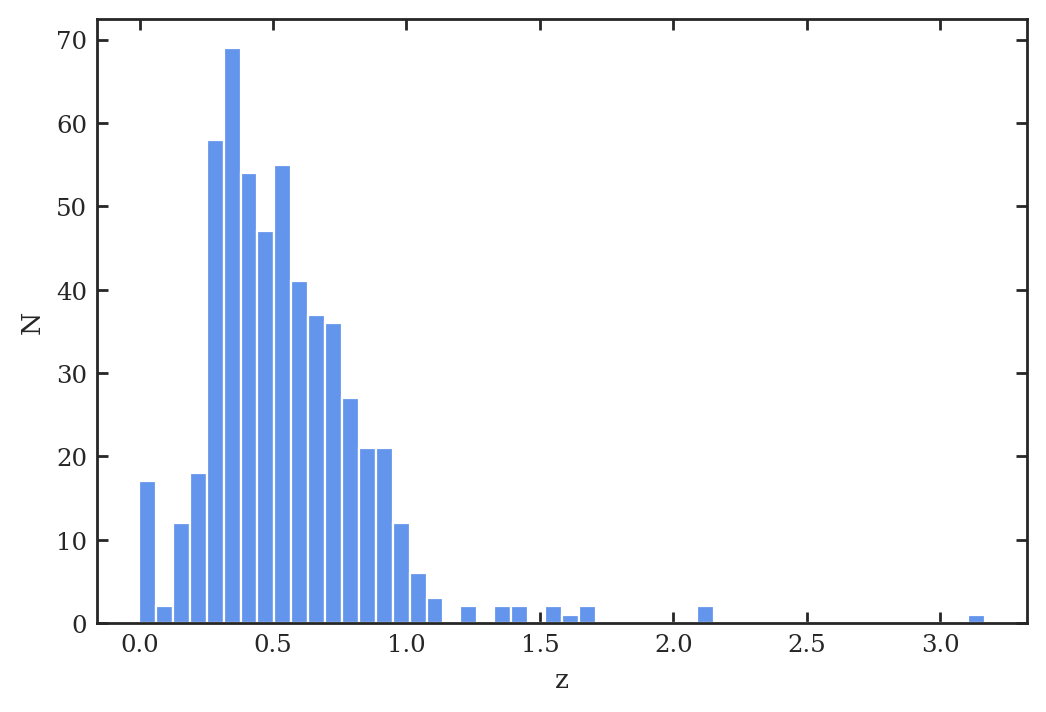

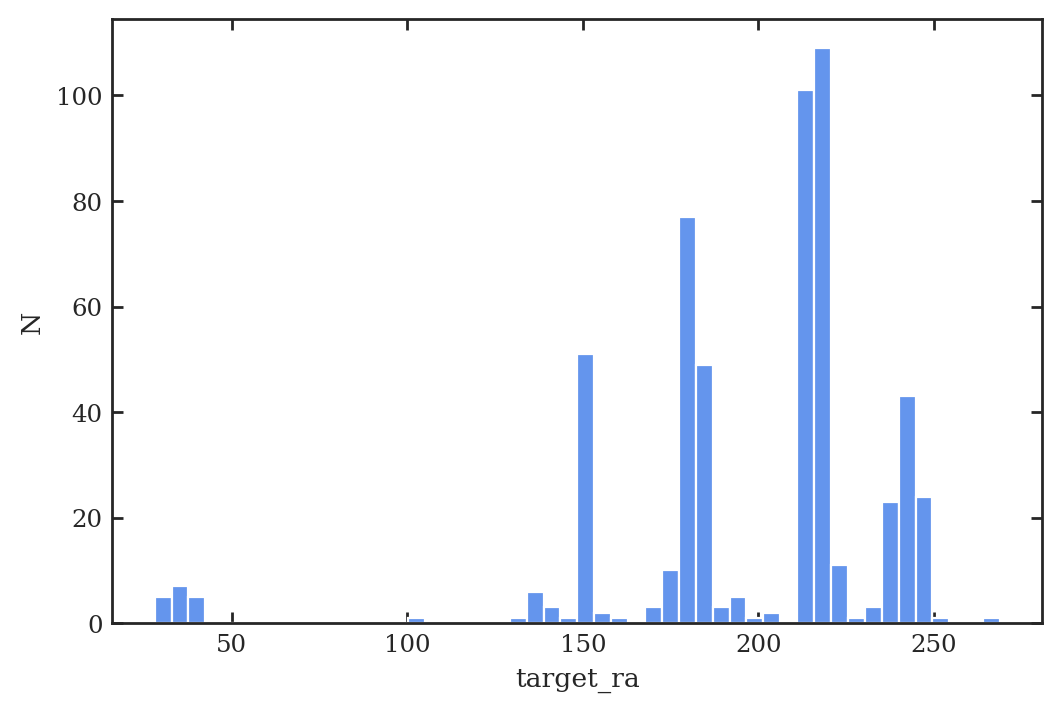

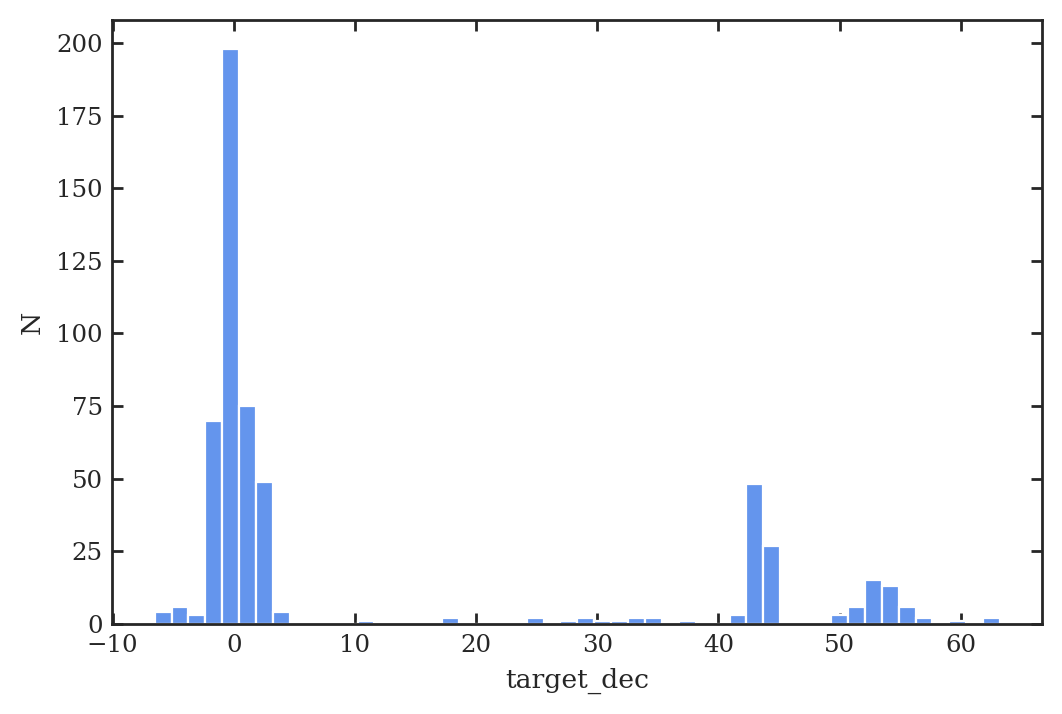

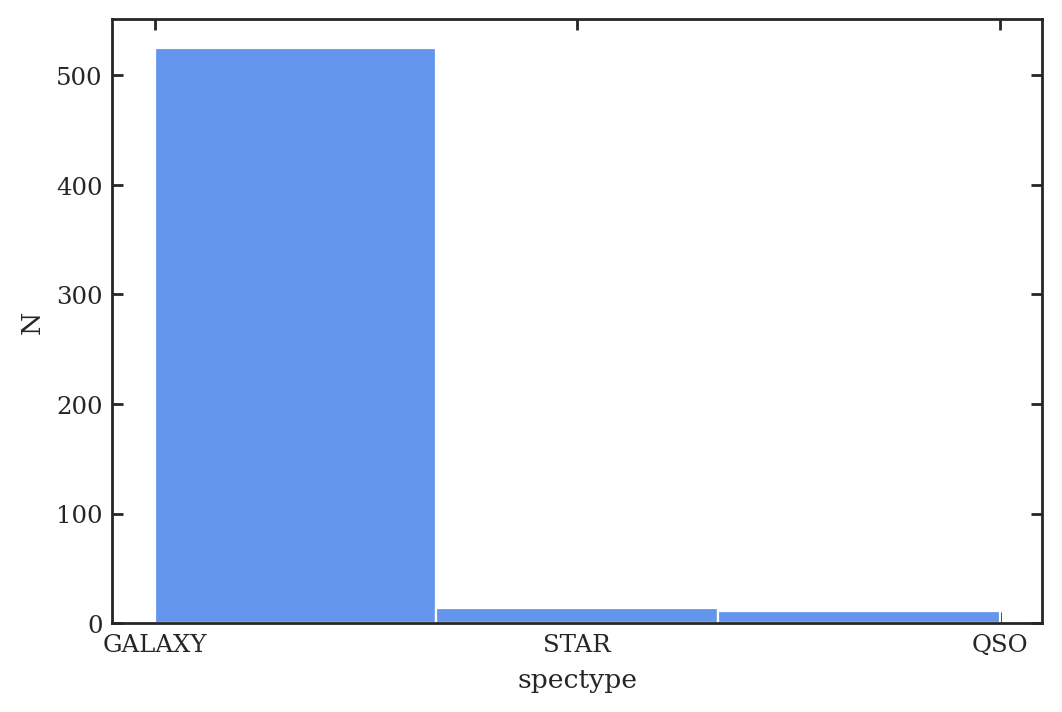

In [5]:
fujiHist('Z', bins=50)
fujiHist('TARGET_RA', bins=50)
fujiHist('TARGET_DEC', bins=50)
fujiHist('SPECTYPE', bins=3)

# Plot Skymap

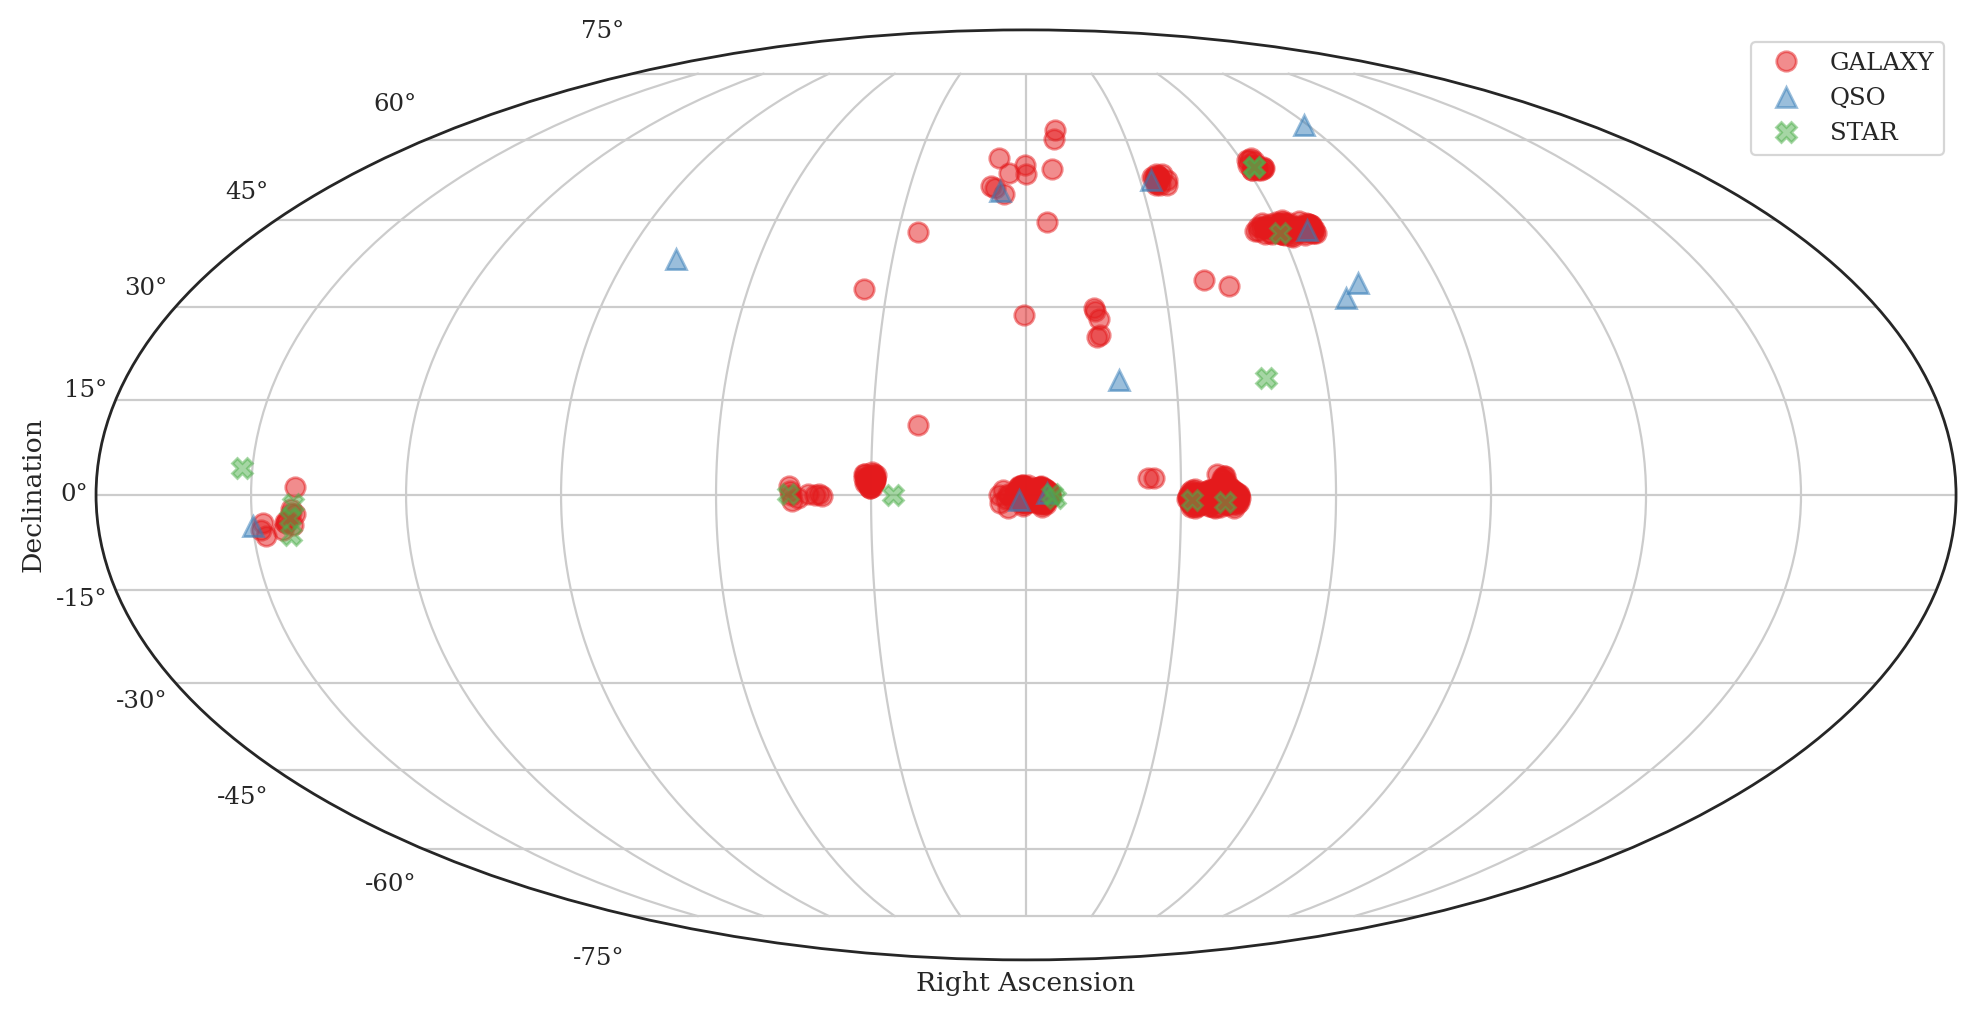

In [6]:
a = 0.5
ms = 7
key = 'SPECTYPE'#'SURVEY'

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection="mollweide")

shapes = ['o', '^', 'X', 'x', '<', '>', 'v']

for val, s in zip(np.unique(fuji[key]), shapes):

    ff = fuji[fuji[key] == val]
    
    targRA = coord.Angle((ff['TARGET_RA']+180)*u.deg)
    targDec = coord.Angle(ff['TARGET_DEC']*u.deg)

    targRA = targRA.wrap_at(180*u.deg)

    ax.plot(targRA.radian, targDec.radian, s, label=val, zorder=2, markersize=ms, alpha=a)

ax.grid()
ax.set_xticklabels([])
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
_=ax.legend(loc='upper right')
fig.savefig('mollweide-projection-matches.png', bbox_inches='tight', transparent=False)

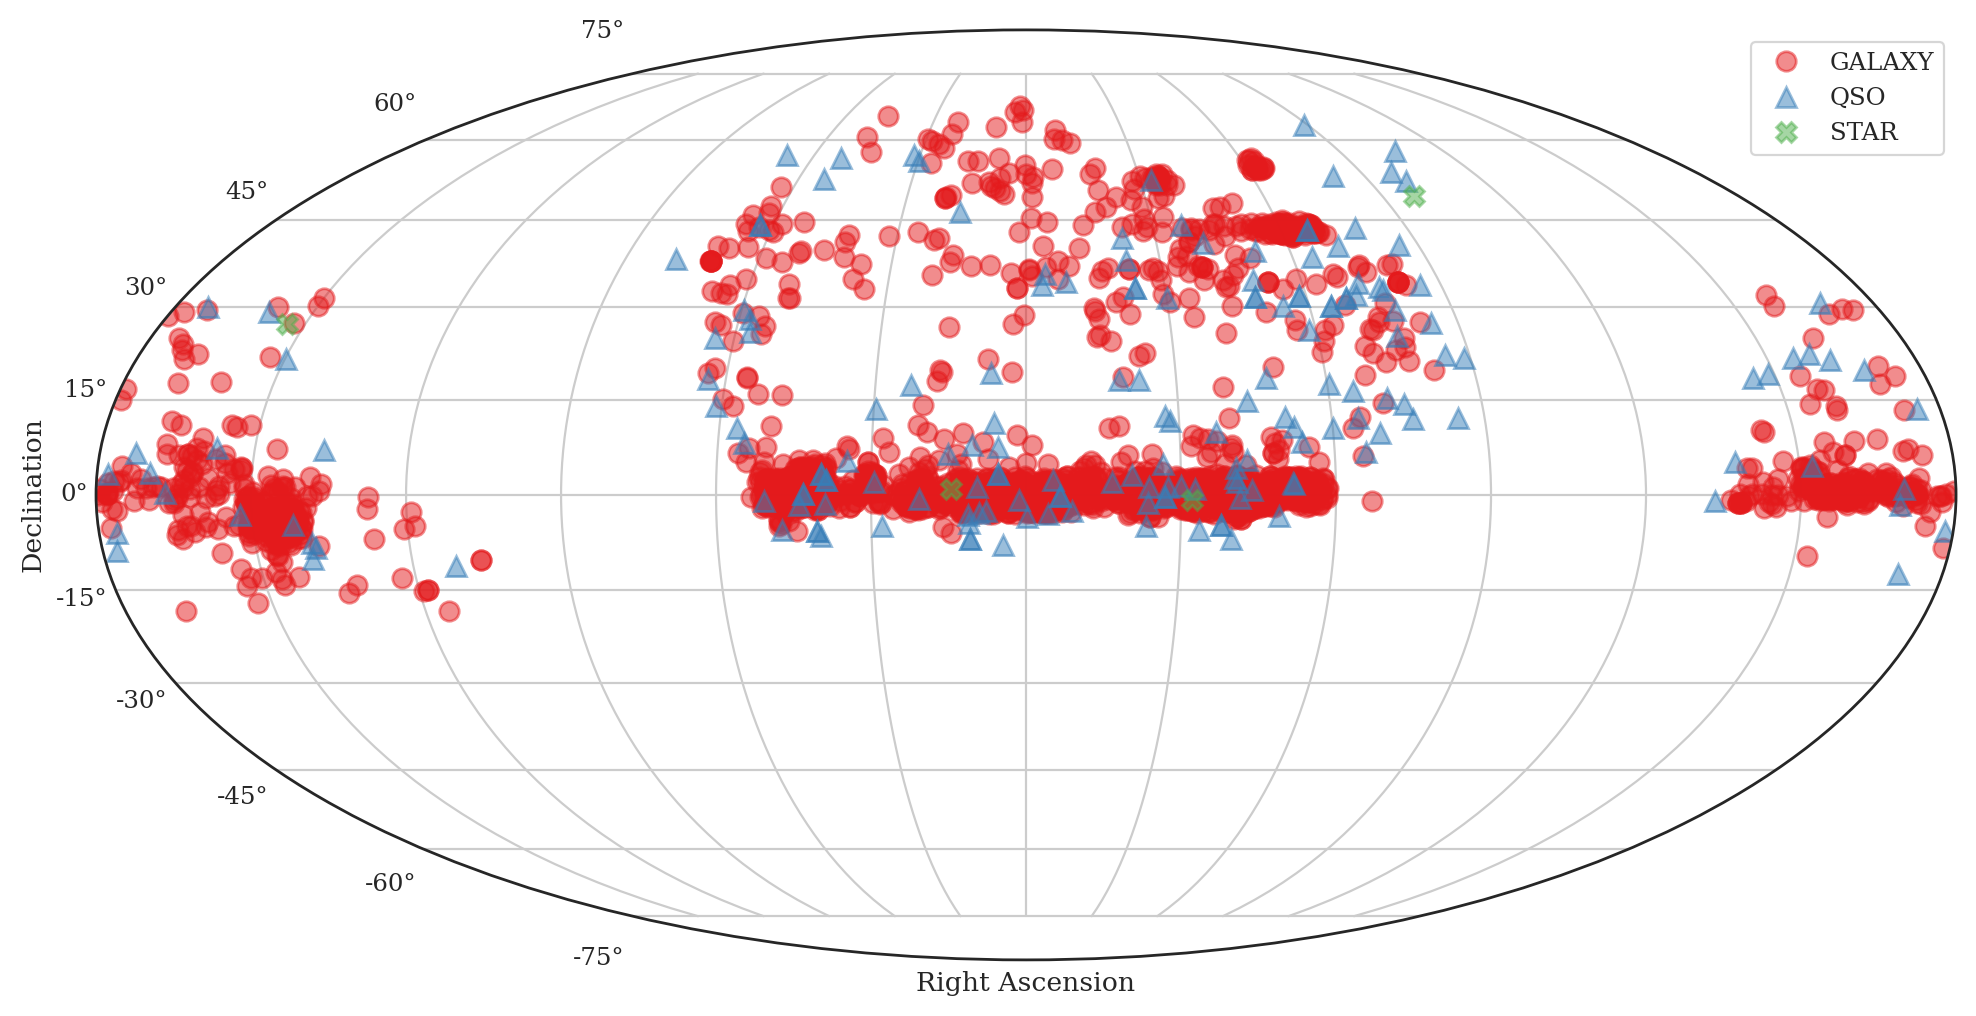

In [7]:
a = 0.5
ms = 7
key = 'SPECTYPE'#'SURVEY'

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection="mollweide")

shapes = ['o', '^', 'X', 'x', '<', '>', 'v']

for val, s in zip(np.unique(iron[key]), shapes):

    ff = iron[iron[key] == val]
    
    targRA = coord.Angle((ff['TARGET_RA']+180)*u.deg)
    targDec = coord.Angle(ff['TARGET_DEC']*u.deg)

    targRA = targRA.wrap_at(180*u.deg)

    ax.plot(targRA.radian, targDec.radian, s, label=val, zorder=2, markersize=ms, alpha=a)

ax.grid()
ax.set_xticklabels([])
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
_=ax.legend(loc='upper right')
fig.savefig('mollweide-projection-matches.png', bbox_inches='tight', transparent=False)

1361/3010 objects have lens redshifts in masterlens


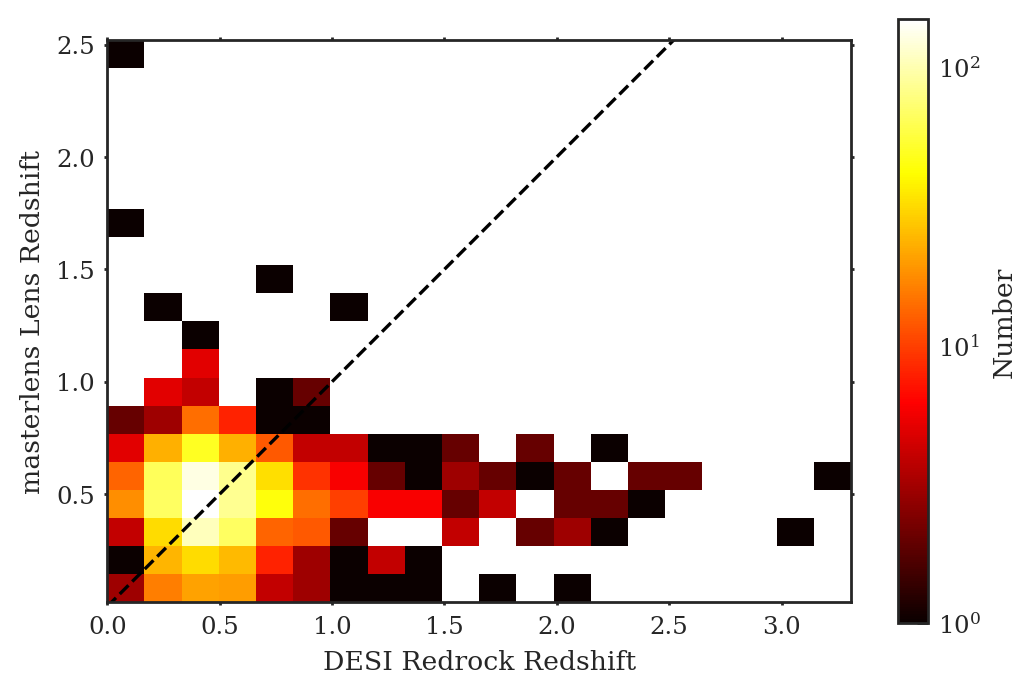

In [68]:
# compare masterlens redshifts to desi redshifts

from matplotlib.colors import LogNorm

masterlens = Table(fitsio.read('masterlens-matches.fits'))

z = hstack([masterlens['Z_LENS'].astype(float), iron['Z']])
z = z[~np.isnan(np.array(z['Z_LENS']))]
print(f'{len(z)}/{len(iron)} objects have lens redshifts in masterlens')

fig, ax = plt.subplots()
#ax.plot(z['Z'], z['Z_LENS'], '.')
count, xedge, yedge, im = ax.hist2d(z['Z'], z['Z_LENS'],
                                    bins=20,
                                    cmap='hot',
                                    norm=LogNorm())
ax.set_ylabel('masterlens Lens Redshift')
ax.set_xlabel('DESI Redrock Redshift')

xy = np.linspace(np.min(z['Z']), np.max(z['Z']))
ax.plot(xy, xy, 'k--')

ax.set_aspect('equal')
ax.tick_params(axis='both',
               which='major',
               direction='out',
               length=1)
fig.colorbar(im, label='Number')
fig.savefig('redshift-comparison-2dhist.png',
            bbox_inches='tight',
            transparent=False)